In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
import nltk.tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

In [233]:
df = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', delimiter='\t')


In [234]:
df['sentiment_label'].value_counts()

4    80000
0    80000
Name: sentiment_label, dtype: int64

In [235]:
#checking for duplicate and missing values
df.drop_duplicates(subset='tweet_text',inplace=True)
df.isnull().sum()

sentiment_label    0
tweet_text         0
dtype: int64

In [236]:
df = df.reset_index(drop=True)

In [237]:
df['sentiment_label'].value_counts()

4    79774
0    79630
Name: sentiment_label, dtype: int64

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159404 entries, 0 to 159403
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  159404 non-null  int64 
 1   tweet_text       159404 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [239]:
df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You Already had your rice's bowl for lunch ?"
1,4,Ughhh layin downnnn Waiting for zeina to cook breakfast
2,0,"@greeniebach I reckon he'll play, even if he's not 100%...but i know nothing!! ;) It won't be the same without him."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has closed down. One of the few web services that I've used for over 5 years


<AxesSubplot:xlabel='sentiment_label', ylabel='count'>

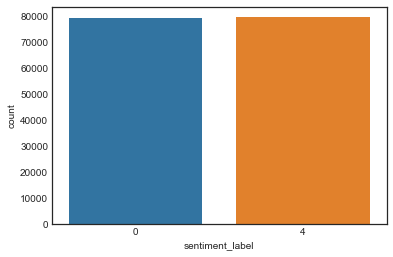

In [240]:
import seaborn as sns 

sns.countplot(x='sentiment_label', data=df)

In [241]:
# get a word count per sentence column

def word_count(sentence):
    return len(sentence.split())

df['word count'] = df['tweet_text'].apply(word_count)
df

,sentiment_label,tweet_text,word count
0,4,"@elephantbird Hey dear, Happy Friday to You Already had your rice's bowl for lunch ?",15
1,4,Ughhh layin downnnn Waiting for zeina to cook breakfast,9
2,0,"@greeniebach I reckon he'll play, even if he's not 100%...but i know nothing!! ;) It won't be the same without him.",21
3,0,@vaLewee I know! Saw it on the news!,8
4,0,very sad that http://www.fabchannel.com/ has closed down. One of the few web services that I've used for over 5 years,20
...,...,...,...
159399,0,STILL @ panera...studying for &quot;mock&quot; board exams tomorrow!! So tired.,10
159400,0,Insomnia is out of control tonight--haven't slept a wink.,9
159401,4,@Covergirl08 I take pride in what I do,8
159402,4,heading to work on the 6,6


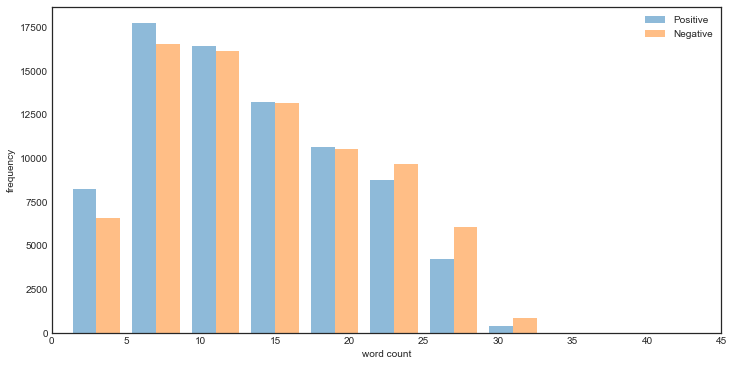

In [242]:
import matplotlib.pyplot as plt
#plot word count distribution for both + and - sentiment
x = df['word count'][df.sentiment_label == 4]
y = df['word count'][df.sentiment_label == 0]

plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x,y], alpha=0.5, label=['Positive', 'Negative'])
plt.legend(loc='upper right')

In [243]:
from collections import Counter

# get most common work in training dataset
all_words = []
for line in list(df['tweet_text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
        
Counter(all_words).most_common(10)

[('i', 74411),
 ('to', 55814),
 ('the', 51508),
 ('a', 37726),
 ('my', 31461),
 ('and', 29770),
 ('you', 23700),
 ('is', 23174),
 ('for', 21488),
 ('in', 20980)]

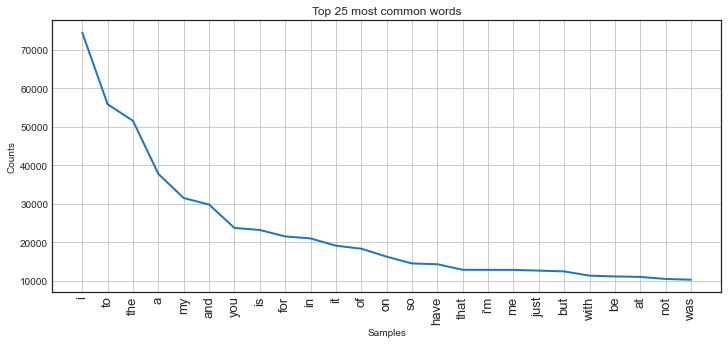

Text(0.5, 1.0, 'log-log plot of words frequency')

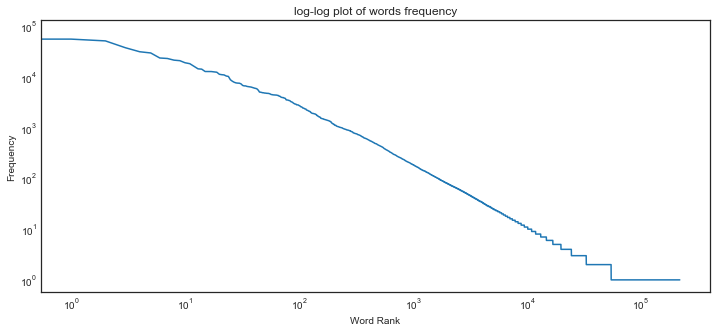

In [244]:
# plot word frequency distribution of firdt few words
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25, cumulative=False)

#log-log
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Frequency")
plt.xlabel('Word Rank')
plt.title('log-log plot of words frequency')

In [245]:
stops = set(stopwords.words('english'))

def cleanText(text): 
    text = re.sub(r'@[A-Za-z0-9]+',' ', text)     #remove @mention
    text = re.sub(r'(?:\@|https?\://)\S+', ' ', text) #remove URLs
    #text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)   # Remove single characters from the start
    text = re.sub(r'\s+[a-zA-Z]\s+',' ', text)    # Single character removal
    text = re.sub('[^a-zA-Z]', ' ', text)       # Remove punctuations and numbers
    text = re.sub(r'\W', ' ', str(text))         # Remove all the special characters
    text = re.sub(r'\b\w{1,2}\b', ' ', text)    # Remove words with 2 or fewer letters
    text = re.sub(r'\s+',' ', text)              # Removing multiple spaces 
    text = text.lstrip().lower()
    removed_stop =  [word for word in text.split() if word not in stops]
    #removed_stop = ' '.join(removed_stop)
    return removed_stop


In [246]:
df['tweet_text'] =df['tweet_text'].apply(cleanText)

In [247]:
df['tweet_text'][:10]

0    [hey, dear, happy, friday, already, rice, bowl, lunch]                                   
1    [ughhh, layin, downnnn, waiting, zeina, cook, breakfast]                                 
2    [reckon, play, even, know, nothing, without]                                             
3    [know, saw, news]                                                                        
4    [sad, closed, one, web, services, used, years]                                           
5    [sings, remember, alwaysss, hear, radio, never, catch, artist]                           
6    [god, side, anything, possible]                                                          
7    [stupid]                                                                                 
8    [delved, back, guts, expression, engine, flexible, cms, use, dev, great, clients, though]
9    [awww, take]                                                                             
Name: tweet_text, dtype: object

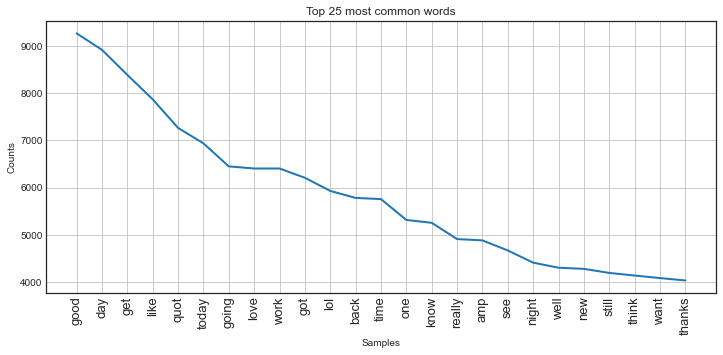

Text(0.5, 1.0, 'log-log plot of words frequency')

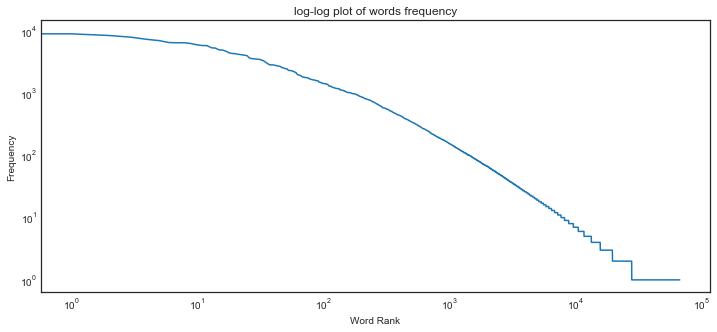

In [248]:
# get most common work in training dataset
X = df['tweet_text']
all_words = []
for i in range(len(X)):
    words = X[i]
    for word in words:
        all_words.append(word.lower())
        
Counter(all_words).most_common(20)
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25, cumulative=False)

#log-log
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Frequency")
plt.xlabel('Word Rank')
plt.title('log-log plot of words frequency')

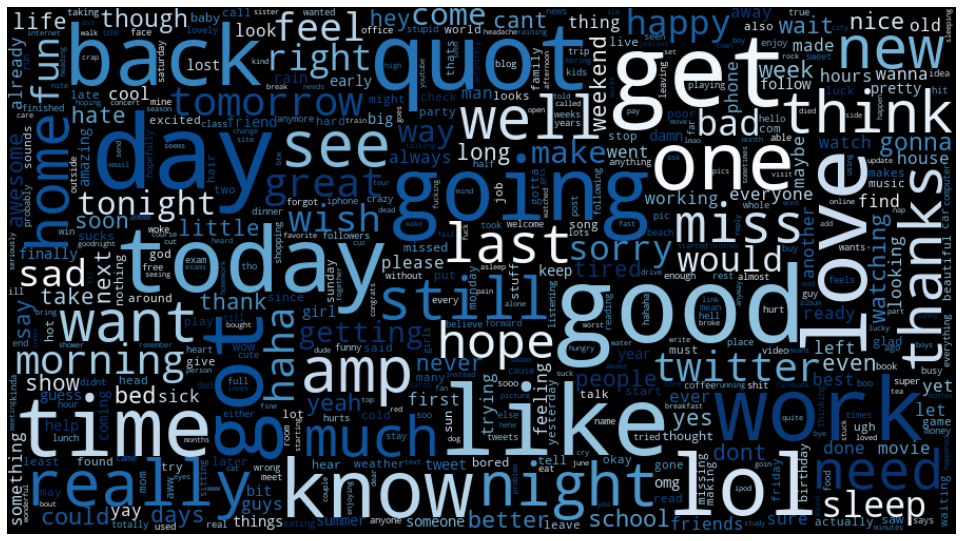

In [249]:
# split sentences to get individual words

sen = list(df['tweet_text'])
all_words = []
for i in range(len(X)):
    words = X[i]
    for word in words:
        all_words.extend(word.split())
    
# create a word frequency dictionary
wordfreq = Counter(all_words)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [250]:
df.drop('word count', axis=1, inplace=True)

In [251]:
X = df['tweet_text']
X[:10]

0    [hey, dear, happy, friday, already, rice, bowl, lunch]                                   
1    [ughhh, layin, downnnn, waiting, zeina, cook, breakfast]                                 
2    [reckon, play, even, know, nothing, without]                                             
3    [know, saw, news]                                                                        
4    [sad, closed, one, web, services, used, years]                                           
5    [sings, remember, alwaysss, hear, radio, never, catch, artist]                           
6    [god, side, anything, possible]                                                          
7    [stupid]                                                                                 
8    [delved, back, guts, expression, engine, flexible, cms, use, dev, great, clients, though]
9    [awww, take]                                                                             
Name: tweet_text, dtype: object

In [252]:
y = df['sentiment_label'].values
y = np.array(list(map(lambda x:1 if x == 4 else 0, y)))
len(y)

159404

In [253]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [254]:
embeddings_dictionary

{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

In [255]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [256]:
from keras.preprocessing.text import Tokenizer


tokenizer = Tokenizer(num_words=5000)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100


In [257]:


#Tokenize
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)

X_tokenize = tokenizer.texts_to_sequences(X)
#X_test_tokenize = tokenizer.texts_to_sequences(X_test)



In [258]:
X_tokenize[:10]

[[65, 475, 44, 198, 102, 1492, 1927, 227],
 [1928, 3594, 178, 962, 372],
 [3348, 184, 68, 15, 150, 244],
 [15, 156, 307],
 [38, 776, 14, 812, 3414, 329, 328],
 [4098, 357, 153, 735, 75, 480, 2432],
 [183, 499, 223, 1063],
 [269],
 [12, 4793, 3142, 233, 3415, 34, 3274, 52],
 [309, 81]]

In [259]:
from keras.preprocessing.sequence import pad_sequences

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

X_pad = pad_sequences(X_tokenize, padding='post')



In [260]:
X_pad[0]

array([  65,  475,   44,  198,  102, 1492, 1927,  227,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0])

In [261]:
#Split dataset to training and test dataset 
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=.3, 
                                                    random_state=42,
                                                    shuffle=True)

In [262]:
print('X_train = ', X_train.shape)
print('X_test = ', X_test.shape)
print('y_train = ', y_train.shape)
print('y_test = ', y_test.shape)
X_train

X_train =  (111582, 30)
X_test =  (47822, 30)
y_train =  (111582,)
y_test =  (47822,)


array([[ 260,    8,   85, ...,    0,    0,    0],
       [  42,    2,    0, ...,    0,    0,    0],
       [ 272, 2012, 1144, ...,    0,    0,    0],
       ...,
       [   8,    0,    0, ...,    0,    0,    0],
       [ 123,   79,   44, ...,    0,    0,    0],
       [  23,  237, 1304, ...,    0,    0,    0]])

# LogisticRegression


In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [121]:
#X, y = make_classification(random_state=42, shuffle=True)

In [122]:
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=500))

In [123]:
pipe.fit(X_train, y_train)  # apply scaling on training data

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=500, random_state=42))])

In [124]:
pipe.score(X_test, y_test)  

0.508406172891138

# Decision Tree classifier

In [125]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()

In [126]:
DTC.fit(X_train, y_train)

DecisionTreeClassifier()

In [127]:
from sklearn.metrics import accuracy_score


In [128]:
accuracy_score(DTC.predict(X_test), y_test)

0.5728953201455397

# Random Forest Classification


In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import classification_report 

In [130]:
RFC = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42) 

In [131]:
RFC_model = RFC.fit(X_train, y_train)

In [132]:
y_pred = RFC_model.predict(X_test)

In [133]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.65      0.62     23997
           1       0.61      0.56      0.58     23825

    accuracy                           0.60     47822
   macro avg       0.60      0.60      0.60     47822
weighted avg       0.60      0.60      0.60     47822



In [134]:
print(precision_recall_fscore_support(y_test, y_pred))

(array([0.5939452 , 0.60887375]), array([0.6458724 , 0.55525708]), array([0.61882137, 0.5808307 ]), array([23997, 23825], dtype=int64))


# SGD

In [135]:
from sklearn.linear_model import SGDClassifier

In [136]:
clf = SGDClassifier(loss='modified_huber', alpha=0.01, penalty='l2', max_iter=1000, learning_rate='optimal')

In [137]:
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.01, loss='modified_huber')

In [138]:
y_pred = clf.predict(X_test)

In [139]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [140]:

# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix = \n', matrix)

# Classification Report
print('\nClassification Report')
report = classification_report(y_test, y_pred)
print(report)

# Accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('SGD Classifier Accuracy of the model: {:.2f}% '.format(accuracy*100))


Confusion Matrix = 
 [[20109  3888]
 [19910  3915]]

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.84      0.63     23997
           1       0.50      0.16      0.25     23825

    accuracy                           0.50     47822
   macro avg       0.50      0.50      0.44     47822
weighted avg       0.50      0.50      0.44     47822

SGD Classifier Accuracy of the model: 50.24% 


# CNN


In [153]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [154]:
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          6781800   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 6,846,057
Trainable params: 64,257
Non-trainable params: 6,781,800
_________________________________________________________________
None


In [155]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Epoch 1/6
698/698 [==============================] - 16s 23ms/step - loss: 0.5641 - acc: 0.7043 - val_loss: 0.5389 - val_acc: 0.7215
Epoch 2/6
698/698 [==============================] - 21s 30ms/step - loss: 0.5146 - acc: 0.7430 - val_loss: 0.5318 - val_acc: 0.7276
Epoch 3/6
698/698 [==============================] - 25s 36ms/step - loss: 0.4851 - acc: 0.7637 - val_loss: 0.5281 - val_acc: 0.7326
Epoch 4/6
698/698 [==============================] - 20s 29ms/step - loss: 0.4565 - acc: 0.7832 - val_loss: 0.5468 - val_acc: 0.7262
Epoch 5/6
698/698 [==============================] - 20s 28ms/step - loss: 0.4285 - acc: 0.8005 - val_loss: 0.5580 - val_acc: 0.7223
Epoch 6/6
698/698 [==============================] - 21s 30ms/step - loss: 0.4011 - acc: 0.8175 - val_loss: 0.5628 - val_acc: 0.7228


In [156]:
score = model.evaluate(X_test, y_test, verbose=1)

1495/1495 [==============================] - 7s 4ms/step - loss: 0.5645 - acc: 0.7272


In [157]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5644624829292297
Test Accuracy: 0.7272385358810425


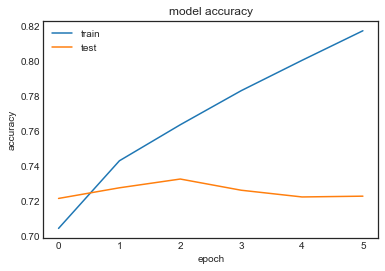

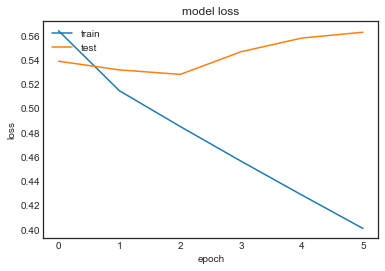

In [158]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# RNN

In [159]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
#model.add(SimpleRNN(100))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])



In [160]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          6781800   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 6,899,177
Trainable params: 117,377
Non-trainable params: 6,781,800
_________________________________________________________________
None


In [161]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
698/698 [==============================] - 65s 93ms/step - loss: 0.5749 - acc: 0.6965 - val_loss: 0.5400 - val_acc: 0.7238
Epoch 2/6
698/698 [==============================] - 75s 108ms/step - loss: 0.5346 - acc: 0.7304 - val_loss: 0.5310 - val_acc: 0.7292
Epoch 3/6
698/698 [==============================] - 77s 110ms/step - loss: 0.5178 - acc: 0.7421 - val_loss: 0.5122 - val_acc: 0.7443
Epoch 4/6
698/698 [==============================] - 75s 107ms/step - loss: 0.5055 - acc: 0.7509 - val_loss: 0.5195 - val_acc: 0.7366
Epoch 5/6
698/698 [==============================] - 80s 114ms/step - loss: 0.4966 - acc: 0.7563 - val_loss: 0.5111 - val_acc: 0.7447
Epoch 6/6
698/698 [==============================] - 81s 115ms/step - loss: 0.4837 - acc: 0.7653 - val_loss: 0.5135 - val_acc: 0.7448


In [162]:
score = model.evaluate(X_test, y_test, verbose=1)

1495/1495 [==============================] - 29s 19ms/step - loss: 0.5178 - acc: 0.7433


In [163]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5177816152572632
Test Accuracy: 0.7432562708854675


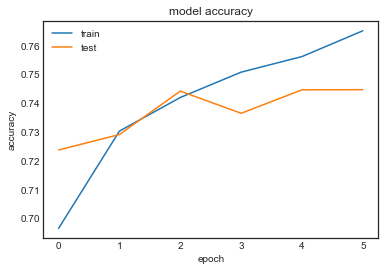

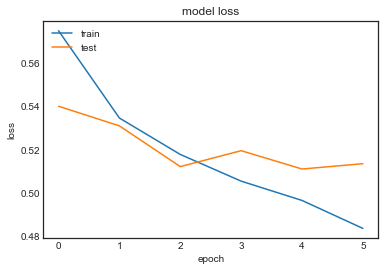

In [164]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()